In [1]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style

In [2]:
stocks = ['AAPL','MSFT','AMZN','TSLA','GOOGL','FB','NVDA','BRK.B','JPM','JNJ']
functions = ['TIME_SERIES_DAILY_ADJUSTED','EMA&interval=daily&time_period=30&series_type=close','EMA&interval=daily&time_period=150&series_type=close']

In [3]:
urls = {}
for i in stocks:
    urls[i] = {}
    for j in functions:
        urls[i][j]='https://www.alphavantage.co/query?function='+j+'&symbol='+i+'&outputsize=full&apikey=6UOESXFNVPGFRYH2&datatype=csv'

#### (Full Access API) Unlimited calls

In [213]:
for key1 in urls:
    for key2 in urls[key1]:
        data = pd.read_csv(urls[key1][key2])
        data.to_csv('data/'+key1+key2+'.csv')

#### (Free API) Manually fetched data one stock at a time. 

In [322]:
for key1 in urls:
    if key1 == 'JNJ':
        for key2 in urls[key1]:
            data = pd.read_csv(urls[key1][key2])
            data.to_csv('data/'+key1+key2+'.csv')

In [4]:
data = {}
for key1 in urls:
    #if key1 == 'AAPL': #subject to change of stocks
        data[key1] = {}
        temp = {}
        for key2 in urls[key1]:
            if key2 == 'TIME_SERIES_DAILY_ADJUSTED':
                df = pd.read_csv('data/'+key1+key2+'.csv',index_col = "timestamp").iloc[:,[5]]
                temp = df
            if key2 == 'EMA&interval=daily&time_period=30&series_type=close':
                df = pd.read_csv('data/'+key1+key2+'.csv',index_col = "time").iloc[:,1:]
                df.rename(columns={"EMA": "EMA30"}, inplace = True)
                temp = temp.merge(df, left_index = True, right_index = True)
            if key2 == 'EMA&interval=daily&time_period=150&series_type=close':#subject to addition of indicators
                df = pd.read_csv('data/'+key1+key2+'.csv', index_col = "time").iloc[:,1:]
                df.rename(columns={"EMA": "EMA150"}, inplace = True)
                temp = pd.merge(temp, df, left_index = True, right_index = True)
        temp.sort_index(ascending = True, inplace = True)
        data[key1] = temp.dropna(axis = 0, how = 'any') #subject to addition of indicators
data['AAPL']

,adjusted_close,EMA30,EMA150
2000-06-05,0.698897,0.7698,0.8292
2000-06-06,0.710838,0.7660,0.8276
2000-06-07,0.739081,0.7642,0.8265
2000-06-08,0.725687,0.7617,0.8251
2000-06-09,0.732881,0.7599,0.8239
...,...,...,...
2021-11-08,150.440000,147.9222,140.4048
2021-11-09,150.810000,148.1085,140.5426
2021-11-10,147.920000,148.0963,140.6403
2021-11-11,147.870000,148.0817,140.7360


In [5]:
calculate = {}
temp = {}
for key in data:
    temp = data[key]
    temp['EMA30Diff'] = temp.diff(1)['EMA30']
    temp['EMA150Diff'] = temp.diff(1)['EMA150']
    temp['EMA30DiffSmooth'] = temp.rolling(5).mean()['EMA30Diff']*100
    temp['EMA150DiffSmooth'] = temp.rolling(5).mean()['EMA150Diff']*100
    temp['30gt150'] = temp['EMA30'] > temp['EMA150']
    temp['up-cross'] = False
    temp['down-cross'] = False
    for i in range(len(temp))[1:-1]:
        temp['up-cross'][i] = (temp.loc[:,'30gt150'][i-1] == False) & (temp.loc[:,'30gt150'][i] == True)
    for i in range(len(temp))[1:-1]:
        temp['down-cross'][i] = (temp.loc[:,'30gt150'][i-1] == True) & (temp.loc[:,'30gt150'][i] == False)    
    temp['buy-signal'] = temp['up-cross'] & (temp['EMA150DiffSmooth']>0)
    temp['sell-signal'] = temp['down-cross'] & (temp['EMA150DiffSmooth']<0)
    temp['1day profit'] = -temp.diff(-1).iloc[:,0]/temp['adjusted_close']
    temp['2day profit'] = -temp.diff(-2).iloc[:,0]/temp['adjusted_close']
    temp['3day profit'] = -temp.diff(-3).iloc[:,0]/temp['adjusted_close']
    temp['5day profit'] = -temp.diff(-5).iloc[:,0]/temp['adjusted_close']
    temp['10day profit'] = -temp.diff(-10).iloc[:,0]/temp['adjusted_close']
    temp['15day profit'] = -temp.diff(-15).iloc[:,0]/temp['adjusted_close']
    temp['30day profit'] = -temp.diff(-30).iloc[:,0]/temp['adjusted_close']
    temp['45day profit'] = -temp.diff(-45).iloc[:,0]/temp['adjusted_close']
    temp['60day profit'] = -temp.diff(-60).iloc[:,0]/temp['adjusted_close']
    temp['90day profit'] = -temp.diff(-90).iloc[:,0]/temp['adjusted_close']
    calculate[key] = temp.dropna(axis = 0, how = 'any')

<ipython-input-5-e27f19ce11f9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['up-cross'][i] = (temp.loc[:,'30gt150'][i-1] == False) & (temp.loc[:,'30gt150'][i] == True)
<ipython-input-5-e27f19ce11f9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp['down-cross'][i] = (temp.loc[:,'30gt150'][i-1] == True) & (temp.loc[:,'30gt150'][i] == False)
<ipython-input-5-e27f19ce11f9>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [10]:
calculate['TSLA']

,adjusted_close,EMA30,EMA150,EMA30Diff,EMA150Diff,EMA30DiffSmooth,EMA150DiffSmooth,30gt150,up-cross,down-cross,...,1day profit,2day profit,3day profit,5day profit,10day profit,15day profit,30day profit,45day profit,60day profit,90day profit
2011-02-07,4.614,5.0988,4.7290,-0.0334,-0.0016,-3.040,-0.014,True,False,False,...,0.061552,0.006068,0.006285,0.000433,-0.052016,0.037711,-0.038145,0.068487,0.156914,0.148678
2011-02-08,4.898,5.0858,4.7313,-0.0130,0.0023,-2.696,0.018,True,False,False,...,-0.052266,-0.052062,-0.050633,-0.067374,-0.108616,-0.019192,-0.093099,0.017967,0.079624,0.082074
2011-02-09,4.642,5.0572,4.7301,-0.0286,-0.0012,-2.710,-0.022,True,False,False,...,0.000215,0.001723,-0.005601,0.065489,-0.029298,0.049548,-0.037915,0.083154,0.168462,0.120638
2011-02-10,4.643,5.0305,4.7289,-0.0267,-0.0012,-2.640,-0.044,True,False,False,...,0.001508,-0.005815,-0.016153,0.016584,0.017015,0.074736,-0.020030,0.101874,0.202240,0.185871
2011-02-11,4.650,5.0059,4.7279,-0.0246,-0.0010,-2.526,-0.054,True,False,False,...,-0.007312,-0.017634,0.063656,-0.003011,0.027527,0.072688,-0.000000,0.076559,0.218495,0.170323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,677.920,640.6853,624.7227,2.5679,0.7141,309.794,75.944,True,False,False,...,0.001446,-0.027053,-0.049077,-0.030933,-0.049711,-0.050950,0.057898,0.082089,0.167335,0.715453
2021-07-02,678.900,643.1508,625.4403,2.4655,0.7176,298.878,76.800,True,False,False,...,-0.028458,-0.050449,-0.038430,0.010016,-0.048137,-0.031345,0.010708,0.109029,0.145323,0.507586
2021-07-06,659.580,644.2107,625.8925,1.0599,0.4522,241.994,68.064,True,False,False,...,-0.022636,-0.010264,-0.003987,0.013584,0.001395,-0.022439,0.009294,0.142955,0.184557,0.619136
2021-07-07,644.650,644.2390,626.1409,0.0283,0.2484,179.788,57.596,True,False,False,...,0.012658,0.019080,0.063678,0.013542,0.016505,0.003614,0.068782,0.170961,0.202947,0.649748


In [6]:
temp = {}
buy = []
sell = []
buy_list = {}
sell_list = {}
buy_profit = {}
sell_profit = {}
for key in calculate:
    temp = calculate[key]
    buy = temp.index[temp['buy-signal'] == True]
    sell = temp.index[temp['sell-signal'] == True]
    buy_list[key] = buy.tolist()
    sell_list[key] = sell.tolist()
    if key == 'AAPL':
        buy_profit = pd.DataFrame(temp[temp['buy-signal'] == True].mean(), columns = [str(key)]).iloc[-10:,:]
        sell_profit = pd.DataFrame(temp[temp['sell-signal'] == True].mean(), columns = [str(key)]).iloc[-10:,:]
    else:
        buy_profit = buy_profit.merge(pd.DataFrame(temp[temp['buy-signal'] == True].mean(), columns = [str(key)]).iloc[-10:,:], left_index = True, right_index = True)
        sell_profit = sell_profit.merge(pd.DataFrame(temp[temp['sell-signal'] == True].mean(), columns = [str(key)]).iloc[-10:,:], left_index = True, right_index = True)

In [7]:
buy_profit

,AAPL,MSFT,AMZN,TSLA,GOOGL,FB,NVDA,BRK.B,JPM,JNJ
1day profit,-0.000801,-0.000920,0.002347,0.002485,-0.001494,-0.000267,0.003430,0.000650,0.010949,-0.002404
2day profit,-0.006552,0.005818,-0.002324,0.013327,-0.006432,0.003496,0.004270,-0.002108,0.008165,0.001906
3day profit,-0.007900,0.008021,0.001644,0.004688,-0.001064,0.016157,0.002243,0.001071,0.010070,0.002737
5day profit,-0.009792,0.003789,-0.008614,-0.001123,0.004500,0.016044,0.003662,-0.000873,0.006833,0.007873
10day profit,-0.008748,0.019937,-0.003500,-0.000767,0.017393,0.060109,0.010091,-0.007642,0.014754,0.014002
15day profit,-0.008152,0.017274,0.002543,0.019921,0.026960,0.057417,0.038247,0.006179,0.010070,0.017974
30day profit,-0.036644,0.048483,0.021333,-0.002177,0.039426,0.128536,0.077264,-0.003204,0.005235,0.024596
45day profit,-0.017583,0.059572,-0.000197,0.003699,0.074354,0.208629,0.168906,-0.004107,-0.016376,0.025370
60day profit,0.000835,0.042484,0.048521,0.058935,0.081789,0.200269,0.178094,-0.006749,-0.004919,0.040205
90day profit,0.093657,0.037208,0.077724,0.145613,0.095544,0.162472,0.198802,-0.005452,0.000096,0.042686


In [8]:
sell_profit

,AAPL,MSFT,AMZN,TSLA,GOOGL,FB,NVDA,BRK.B,JPM,JNJ
1day profit,0.008806,-0.001700,0.006320,-0.006584,0.007745,-0.005960,-0.002270,-0.003040,-0.001367,0.005025
2day profit,0.005398,0.004187,-0.004344,0.000305,0.009562,-0.003666,0.004154,0.008610,0.003146,0.009124
3day profit,0.013117,0.006739,0.002627,0.016336,0.011802,-0.029067,-0.001381,0.021738,0.007956,0.005442
5day profit,-0.009189,0.003092,0.016306,0.035849,0.019853,-0.019910,0.029819,0.019873,0.021128,0.009428
10day profit,-0.038532,0.008401,0.013384,0.061666,0.032800,-0.034241,0.019513,0.005807,0.009230,0.022506
15day profit,-0.055856,0.015781,0.002415,0.050883,0.031100,-0.026764,0.003146,0.007373,0.001864,0.028999
30day profit,-0.072147,0.043187,0.024644,0.033141,0.065951,0.051369,0.028448,0.023240,0.012284,0.045258
45day profit,-0.043512,0.063474,0.035231,0.075905,0.097008,0.154702,0.036839,-0.005020,0.020196,0.049511
60day profit,0.002566,0.070264,0.044096,0.070968,0.118546,0.211823,0.097547,0.004886,0.012343,0.060050
90day profit,0.066450,0.091091,0.101978,0.095394,0.150998,0.330148,0.196461,0.017111,0.023961,0.072473


In [13]:
%matplotlib notebook

<IPython.core.display.Javascript object>


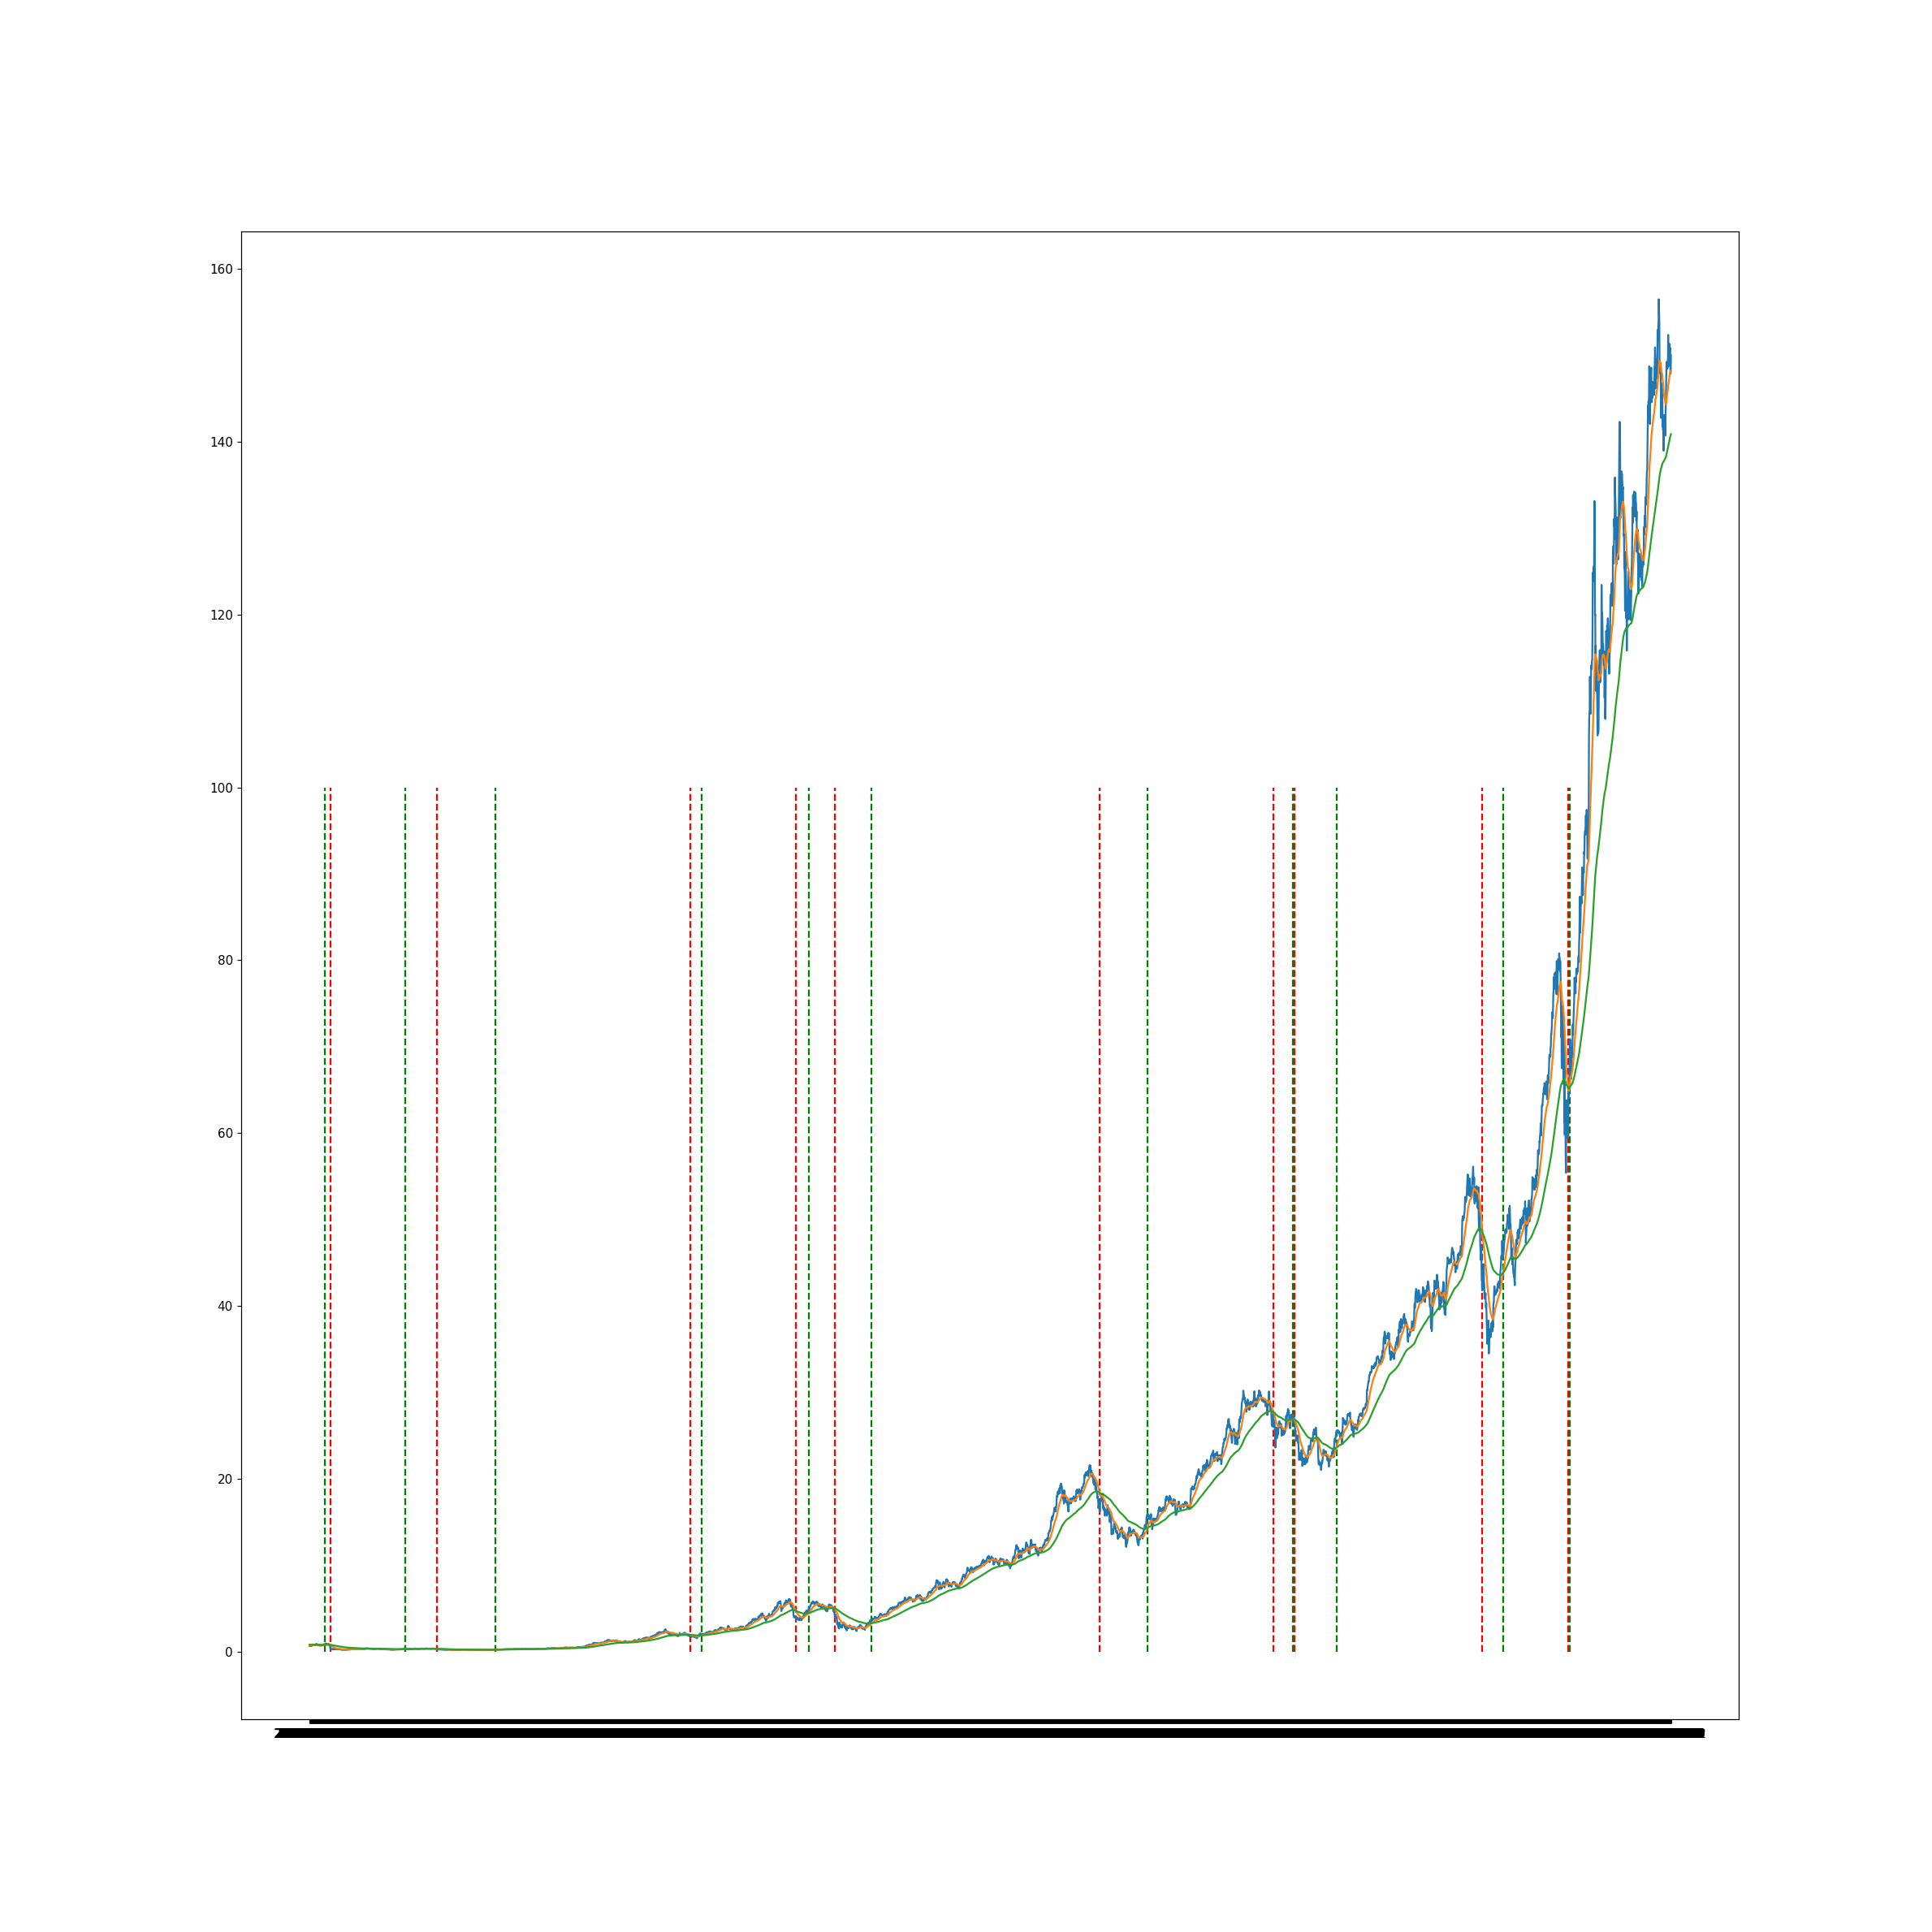

In [14]:
plt.figure(figsize=(15,12))
plt.plot(data['AAPL'].iloc[:,:3])
plt.vlines(x = buy_list['AAPL'], ymin = 0, ymax = 100, linestyles = 'dashed', color = 'green')
plt.vlines(x = sell_list['AAPL'], ymin = 0, ymax = 100, linestyles = 'dashed', color = 'red')


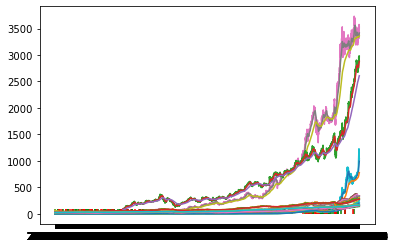

In [12]:
show = {}
for key in data:
    show = data[key].iloc[:,:3]
    plt.plot(show)
    plt.vlines(x = buy_list[key], ymin = 0, ymax = 100, linestyles = 'dashed', color = 'green')
    plt.vlines(x = sell_list[key], ymin = 0, ymax = 100, linestyles = 'dashed', color = 'red')